# Eliminación de aberraciones


**Autor**: Luis Miguel Sánchez Brea.

**Fecha**: 23/07/2019.

**Modo**: make function

**Objetivo**: Calibración del SLM.

**Descripción**: Hemos visto que para una lente estándar, aparece algo de astigmatismo. Ya lo sabíamos pues hay artículos donde lo corregimos. Aquí hacemos un notebook para eliminar y verificar el astigmatismo:


* Lente estándar. Nos movemos a las posiciones focales cercanas. 
* Vemos la aberración y la eliminamos con una función en py_slm.holoeye.remove_astimagtism.
* Cada vez que enviamos una imagen al SLM por procedimiento estándar se añade la fase.
* Si no funciona la fase propuesta se realiza un procedimiento experimental.

## Parámetros

### Cargar librerías

In [1]:
%run config_slm.ipynb

In [2]:
import time
from pprint import pprint
import cv2
import screeninfo
import matplotlib.image as mpimg

In [3]:
from diffractio import degrees, mm, plt, sp, um, np
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_math import ndgrid, nearest
from diffractio.utils_drawing import draw2D
from diffractio.utils_optics import FWHM2D, beam_width_2D

In [4]:
from py_eye.LIO.angular_lens import Angular_lens

In [5]:
from matplotlib import mlab

In [6]:
from py_slm.py_slm import SLM
from py_slm.config import CONF_HOLOEYE2500, CONF_PACKARD_BELL, CONF_IMAGING_SOURCE
from py_slm.config import wavelength, z_ini, time_waitKey

In [7]:
s=1.

## Initiate

### SLM

In [8]:
exp1=SLM(config_SLM=CONF_HOLOEYE2500, config_Camera=CONF_IMAGING_SOURCE, move_motor=True)

x0=exp1.slm.x0
y0=exp1.slm.y0
wavelength=exp1.slm.wavelength

Connecting to SMC100 on COM3
(20.0, 20.0)


###  Motor

In [10]:
exp1.motor.move_absolute(0*mm)
exp1.motor.get_position(verbose=False)

0

### Camera

In [11]:
exp1.camera_set_parameters(exposure=3,gain=-11)

In [12]:
exp1.camera.SetPropertySwitch("Exposure", "Auto", 0)
exp1.camera.SetPropertyValue("Exposure", "Value", -10)

1

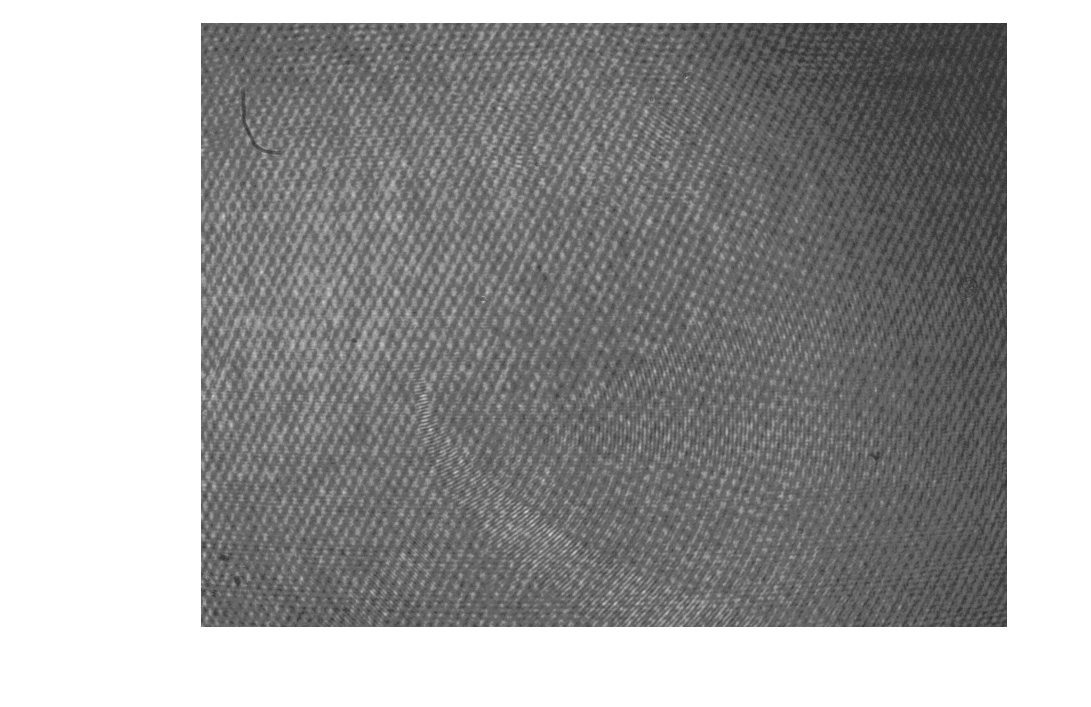

In [18]:
image,_,_=exp1.acquire_image(remove_background=False, gain_exposure=(3,-13), draw=True);

## Imagenes en Modulador

### Parámetros de las lentes

In [19]:
focal=125*mm
radius=(3*mm,3*mm)
r0 = (0 * um, 0 * um)

In [20]:
development=False

if development is True:
    x0=np.linspace(-3*mm,3*mm, 2500)
    y0=np.linspace(-2*mm,2*mm, 2000)
    wavelength=0.6328*um

else:
    x0=exp1.slm.x0
    y0=exp1.slm.y0
    wavelength=exp1.slm.wavelength

### tipo de lente para cargar

In [21]:
tipos_lentes=["standard"]

### Lente estándar

reduce_matrix_size: size ini = (768L, 1024L), size_final = (384L, 1024L)
reduce_matrix_size: size ini = (768L, 1024L), size_final = (384L, 1024L)


((<matplotlib.image.AxesImage at 0xcbbea58>,
  <matplotlib.image.AxesImage at 0xcf612b0>),
 None,
 None)

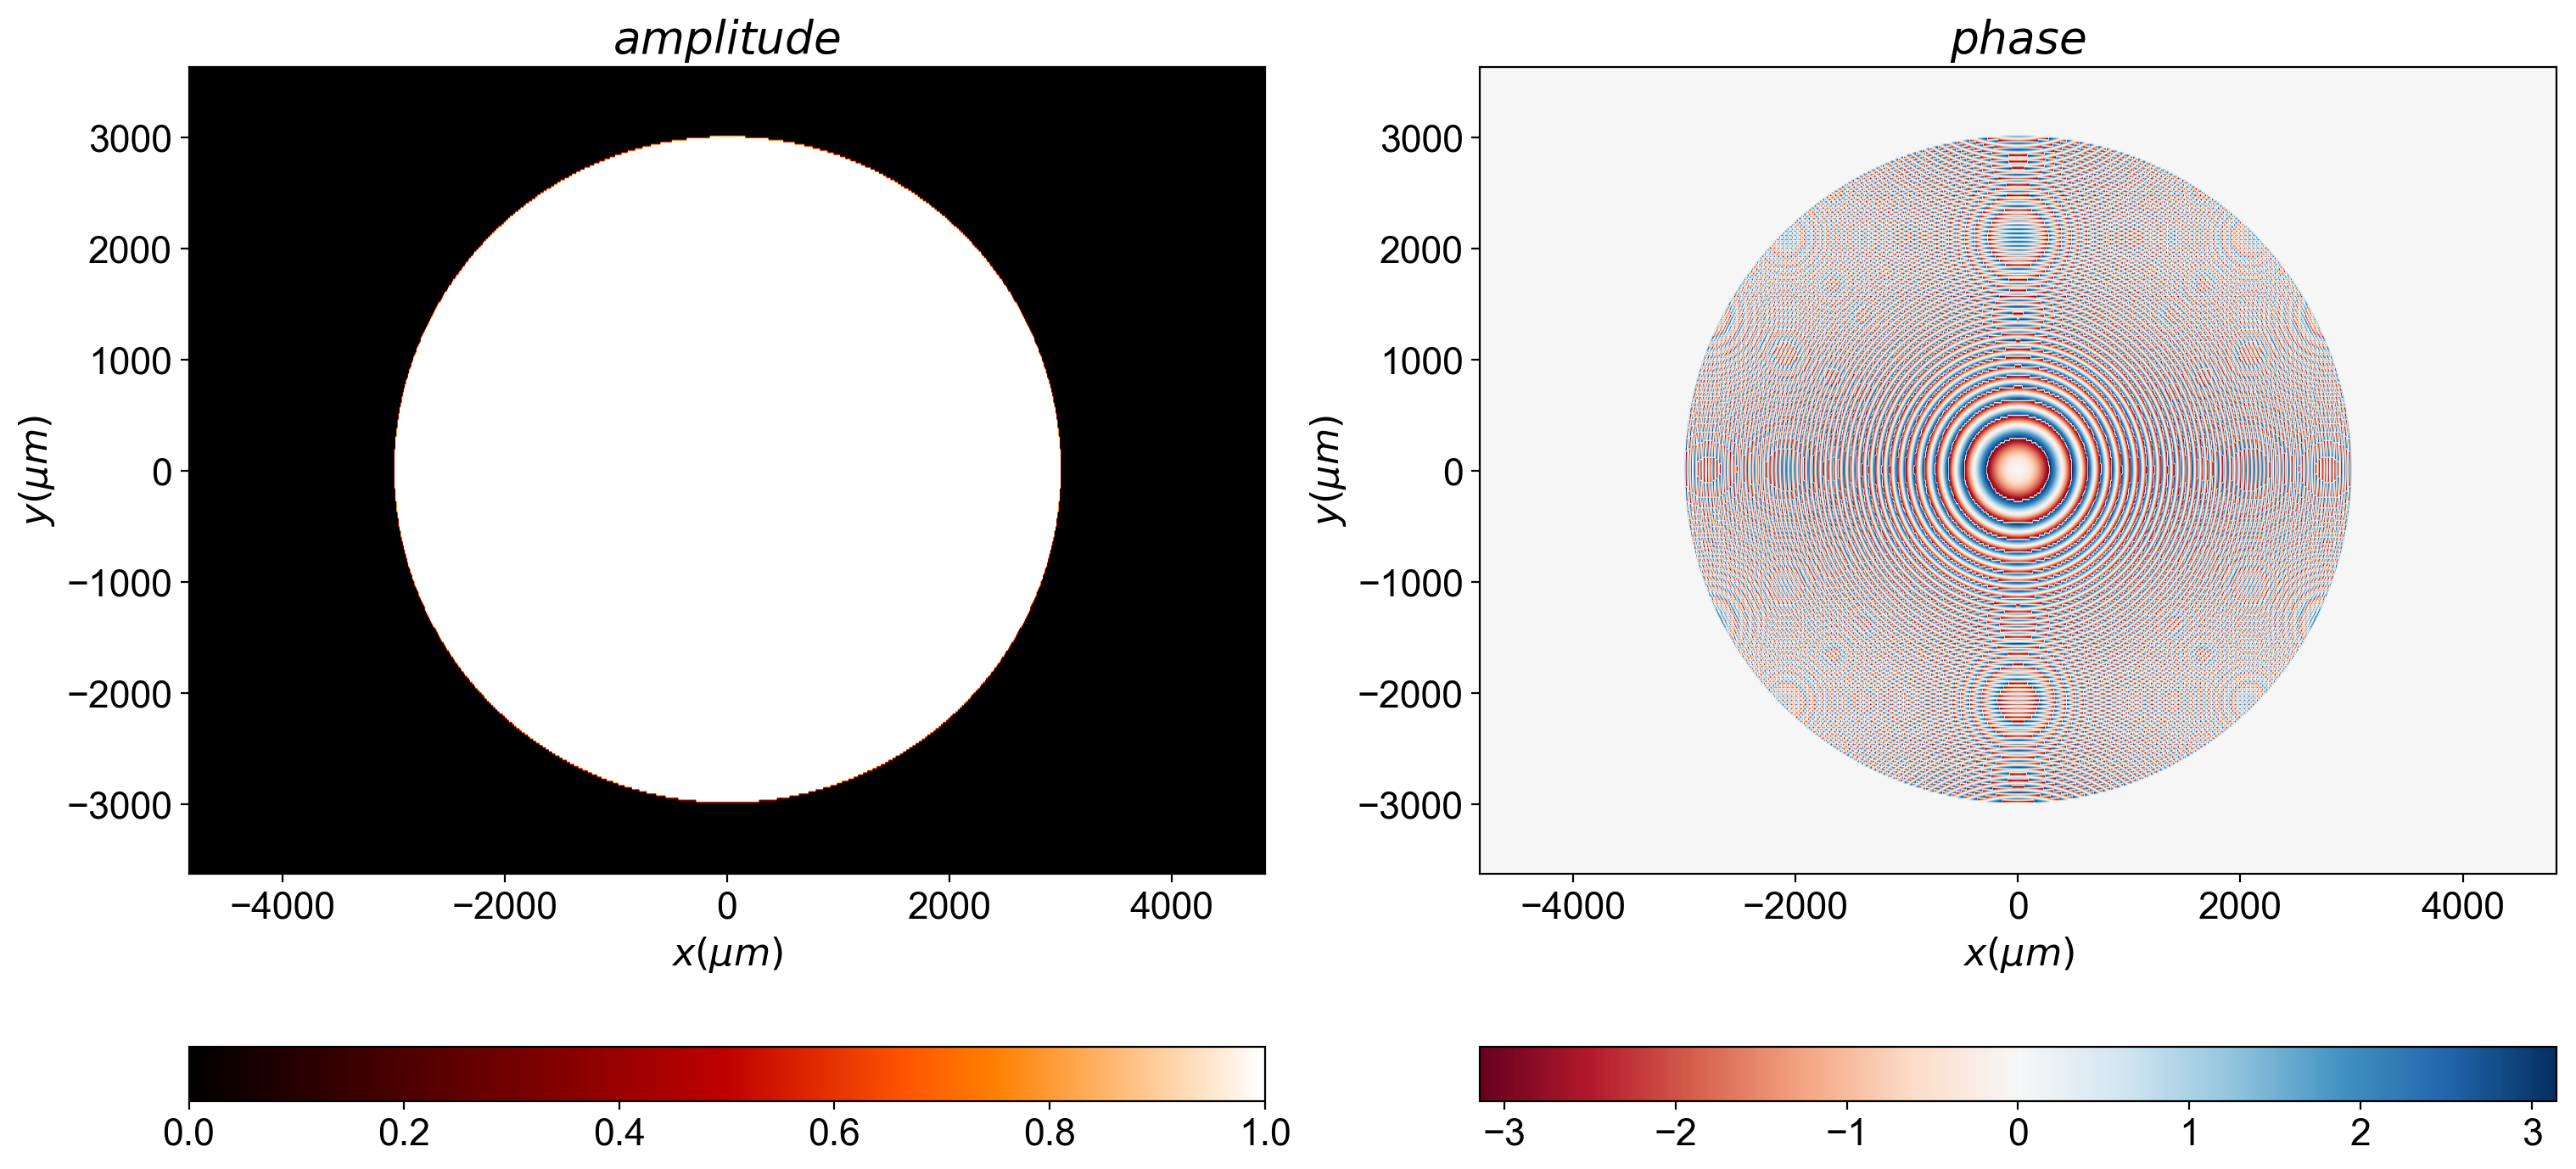

In [22]:
t_lens = Scalar_mask_XY(x0, y0, wavelength)
t_lens.lens(r0 =r0, radius = radius, focal = (focal,focal), angle = 0 * degrees)
t_lens.draw(kind='field')

## enviar lente

In [23]:
def pos_center_image(image):
    result = np.where(image == image.max())
    x_center, y_center = int(result[1].mean()), int(result[0].mean())
    return x_center, y_center

In [28]:
"Enviamos la imagen al SLM."
exp1.slm.mask_to_rawImage(mask_XY=t_lens, kind='phase', normalize=True);
exp1.slm.send_image_screen()
cv2.waitKey(time_waitKey)

(<type 'numpy.ndarray'>, (768L, 1024L))


-1

(1255, 859)


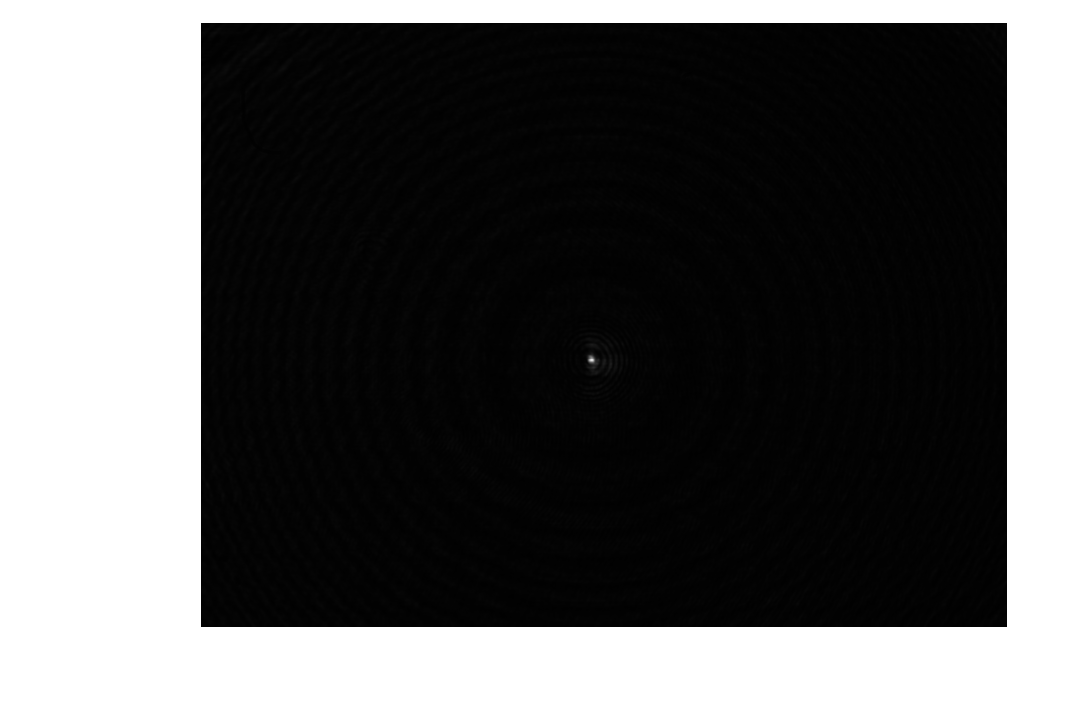

In [30]:
exp1.motor.move_absolute(39.5*mm)

cv2.waitKey(time_waitKey)
image,_,_=exp1.acquire_image(remove_background=False, gain_exposure=(3,-13), draw=True);
x_center, y_center = pos_center_image(image)
print(x_center, y_center)


In [31]:
def recortar_image(image, x, y, center, size, has_drawing=False):
    
    x_new=x[x_center-size[0]:x_center+size[0]]
    y_new=y[y_center-size[1]:y_center+size[1]]

    image_new=image[y_center-size[1]:y_center+size[1], x_center-size[0]:x_center+size[0]]
    if has_drawing is True:
        draw2D(image_new, x_new, y_new,
            xlabel="$x  (\mu m)$", ylabel="$y  (\mu m)$", title="",
            color="RdBu", interpolation='bilinear',  scale='scaled',
            reduce_matrix='standard',         range_scale='mm', verbose=False )
    return image_new, x_new, y_new

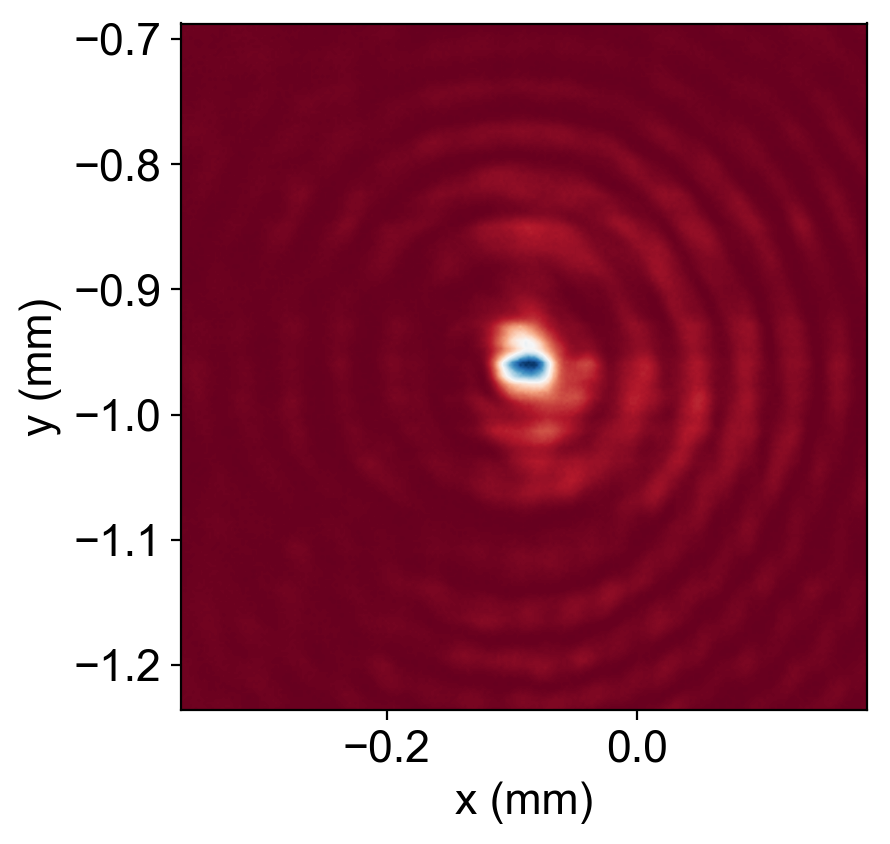

In [32]:
image_new, x_new, y_new = recortar_image(image, exp1.camera.x0, exp1.camera.x0, 
                           center=(x_center, y_center), size=(125,125), has_drawing=True)

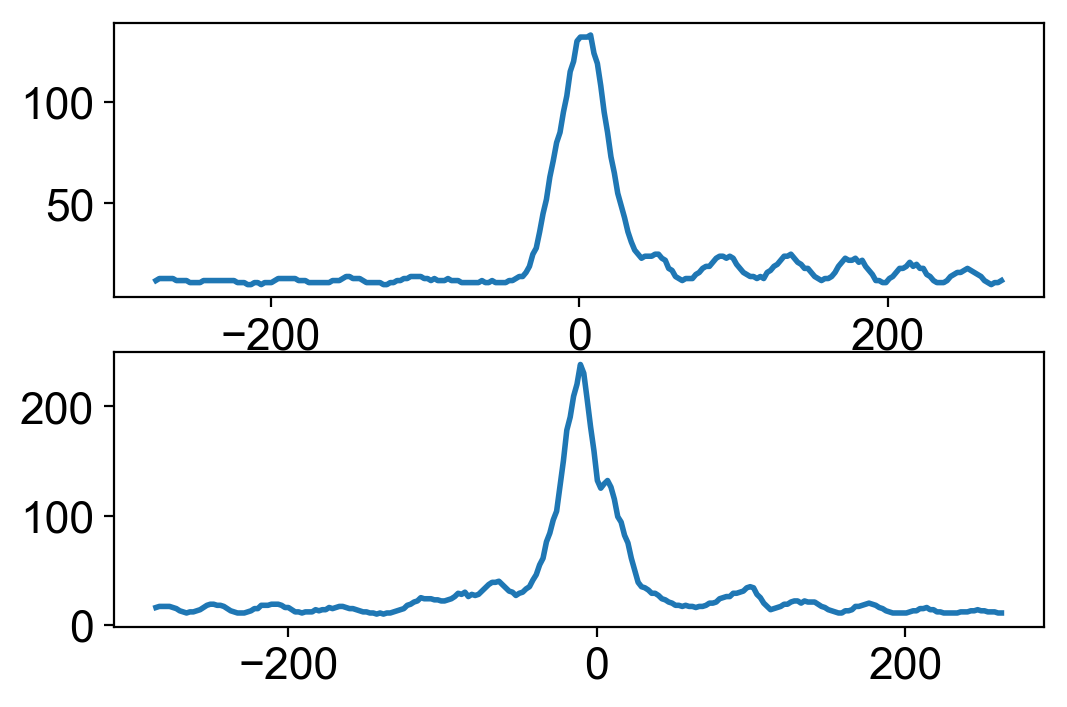

In [44]:
iy,_,_ = nearest(y_new,-0.95*mm)
ix,_,_ = nearest(x_new,-0.09*mm)

plt.figure()
plt.subplot(2,1,1)
plt.plot(x_new+0.09*mm,image_new[iy,:])
plt.subplot(2,1,2)

plt.plot(y_new+0.95*mm,image_new[:,ix])

